In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import arviz as az
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import halfnorm
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme()
az.style.use('arviz-darkgrid')
np.random.seed(44)

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


# Pooled model

In [2]:
path = r"/Users/christian/supsi/bayesian_retry/retry/points_df.csv"
points_df = pd.read_csv(path, index_col=0)
points_df

,total,home,away,EHC Biel-Bienne (away),HC Lugano (away),ZSC Lions (home),HC Ambri-Piotta (away),SC Bern (home),EV Zug (home),Genève-Servette HC (away),...,ZSC Lions (away),HC Ambri-Piotta (home),SC Bern (away),EV Zug (away),Genève-Servette HC (home),EHC Biel-Bienne (home),SC Rapperswil-Jona Lakers (away),Lausanne HC (home),HC Ajoie (home),HC Ajoie (away)
HC Ajoie,89,53,36,7.0,14.0,13.0,4.0,8.0,13.0,7.0,...,10.0,5.0,8.0,8.0,7.0,11.0,12.0,7.0,0.0,0.0
EHC Biel-Bienne,168,91,77,0.0,2.0,15.0,2.0,6.0,7.0,3.0,...,15.0,6.0,9.0,4.0,8.0,0.0,4.0,5.0,2.0,1.0
SC Bern,136,75,61,11.0,4.0,4.0,7.0,0.0,7.0,7.0,...,2.0,6.0,0.0,5.0,5.0,14.0,5.0,11.0,3.0,1.0
Fribourg-Gottéron,185,104,81,4.0,4.0,18.0,3.0,3.0,6.0,4.0,...,9.0,8.0,7.0,7.0,5.0,5.0,3.0,15.0,1.0,4.0
ZSC Lions,210,117,93,15.0,6.0,0.0,4.0,8.0,16.0,7.0,...,0.0,2.0,4.0,13.0,6.0,8.0,4.0,7.0,8.0,4.0
Genève-Servette HC,155,82,73,4.0,9.0,11.0,13.0,7.0,6.0,0.0,...,1.0,3.0,2.0,4.0,0.0,7.0,1.0,5.0,7.0,5.0
EV Zug,223,127,96,5.0,9.0,5.0,6.0,7.0,0.0,9.0,...,13.0,7.0,3.0,0.0,7.0,7.0,5.0,7.0,3.0,3.0
HC Davos,169,91,78,2.0,2.0,11.0,3.0,6.0,18.0,2.0,...,6.0,5.0,4.0,6.0,6.0,5.0,15.0,4.0,6.0,0.0
HC Lugano,175,87,88,8.0,0.0,10.0,4.0,5.0,24.0,7.0,...,7.0,6.0,3.0,22.0,7.0,8.0,3.0,12.0,5.0,2.0
SC Rapperswil-Jona Lakers,182,103,79,7.0,7.0,8.0,6.0,6.0,3.0,3.0,...,10.0,6.0,4.0,3.0,6.0,5.0,0.0,4.0,5.0,5.0


In [3]:
# not sure about what to include in x and y...
x = points_df.iloc[:, 3:13].values
y = points_df.iloc[:, 13:].values.astype(np.float64).T

mu_y = y.mean()
s_y = y.std()
s_x = x.std()
x.shape,y.shape

#((13, 26), (3, 13))

((13, 10), (16, 13))

In [4]:
# model
with pm.Model() as pooled_model:
    # priors:
    alpha = pm.Normal('alpha', mu=mu_y, sigma=s_y)
    beta = pm.Normal('beta', mu=0, sigma=s_x, shape=10)
    sigma = pm.HalfNormal('sigma', sigma=s_y)

    # likelihood:
    mu = alpha + pm.math.dot(x, beta)

    y_pred = pm.StudentT ('y_pred', nu=3.6, mu=mu, sd=sigma, observed=y)

    # inference:
    trace_pooled = pm.sample(1000, tune=1000, cores=2, chains=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.


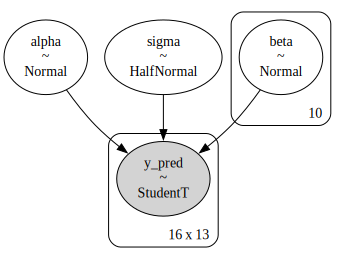

In [5]:
pm.model_to_graphviz(pooled_model)

## Checking convergence

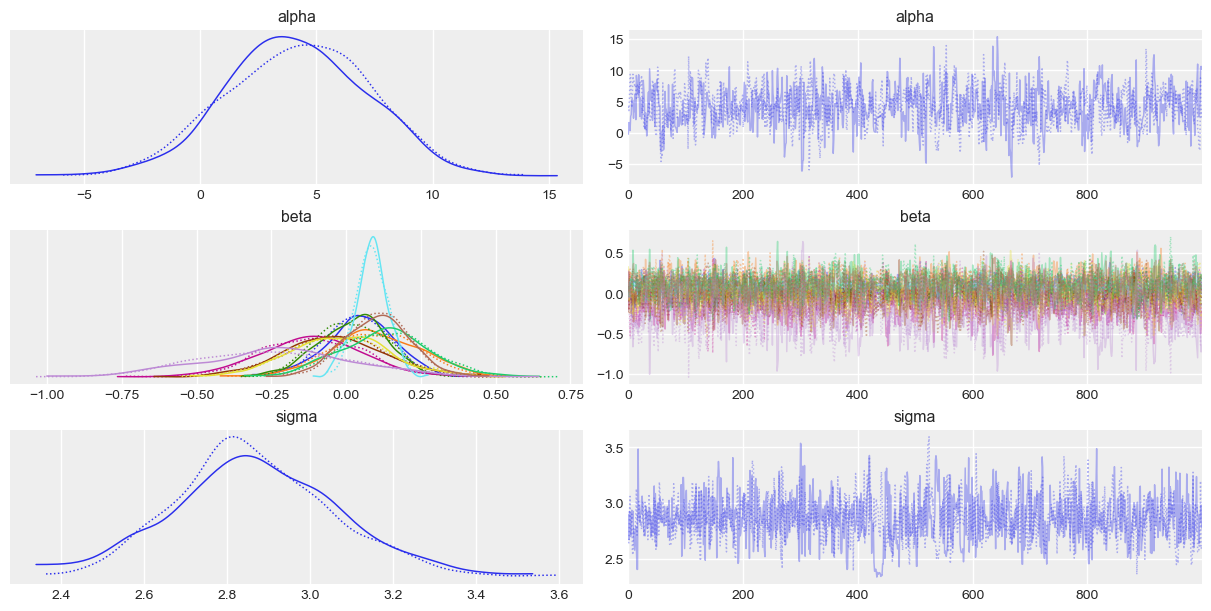

In [6]:
with pooled_model:
    az.plot_trace(trace_pooled);

In [7]:
az.summary(trace_pooled)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,4.170,3.131,-1.708,9.706,0.123,0.087,654.0,749.0,1.00
beta[0],0.043,0.114,-0.173,0.258,0.004,0.003,910.0,1257.0,1.00
beta[1],0.096,0.154,-0.191,0.388,0.006,0.004,722.0,1065.0,1.00
beta[2],0.020,0.116,-0.183,0.233,0.005,0.003,647.0,792.0,1.00
beta[3],-0.114,0.176,-0.458,0.199,0.006,0.004,775.0,900.0,1.00
beta[4],-0.039,0.170,-0.341,0.315,0.006,0.004,779.0,905.0,1.00
beta[5],0.086,0.054,-0.014,0.192,0.002,0.001,1159.0,1172.0,1.00
beta[6],-0.024,0.169,-0.354,0.300,0.007,0.005,654.0,871.0,1.00
beta[7],0.129,0.152,-0.147,0.411,0.006,0.004,725.0,1040.0,1.00
beta[8],-0.233,0.262,-0.729,0.244,0.011,0.007,621.0,928.0,1.01


## Predictive checks

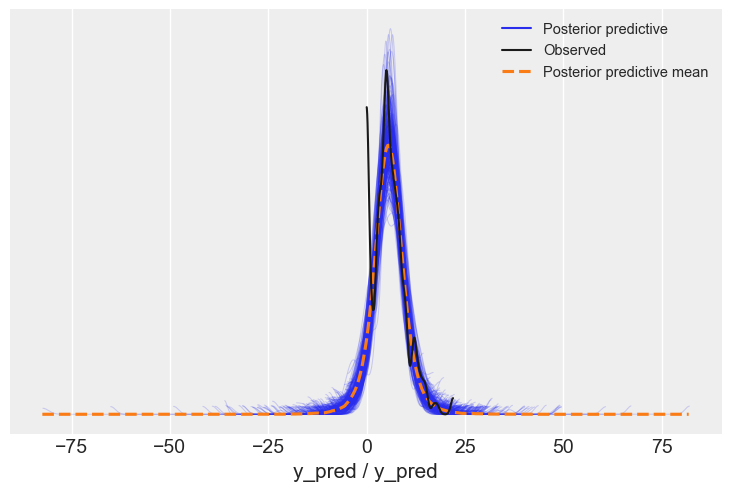

In [8]:
with pooled_model:
     ppc = pm.sample_posterior_predictive(trace_pooled, samples=300)
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=pooled_model));

### mean HC Lugano

In [9]:
hcl_idx = points_df.index.to_list().index('HC Lugano')
# print(hcl_idx)
x_hcl = np.array(x)[hcl_idx, :]
x_hcl

array([ 8.,  0., 10.,  4.,  5., 24.,  7.,  3.,  5.,  6.])

In [10]:
post_pool = az.extract_dataset(trace_pooled.posterior)
alpha_samples = post_pool.alpha.values.reshape(2000)
beta_samples = post_pool.beta.values.reshape(2000, 10)
mu_team = alpha_samples + np.dot(x_hcl, beta_samples.T)

/var/folders/n3/51xp5_rs54v10cnshxhwyt480000gn/T/ipykernel_13289/177089194.py:1: FutureWarning: extract_dataset has been deprecated, please use extract
  post_pool = az.extract_dataset(trace_pooled.posterior)


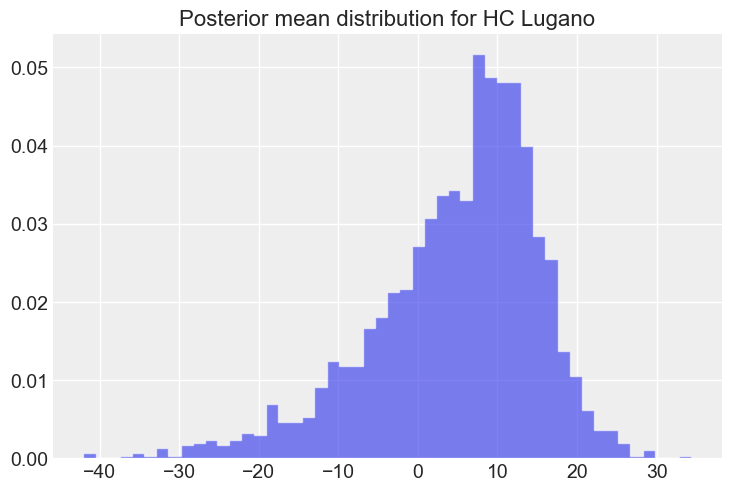

HC Lugano predicted mean: 4.785
HC Lugano predicted mean standard deviation: 10.445


In [11]:
# plot the posterior predictive distribution
plt.hist(mu_team, bins=50, density=True, histtype='stepfilled', alpha=0.6)
plt.title('Posterior mean distribution for HC Lugano')
plt.show()

# print the mean and standard deviation of the posterior predictive distribution
print(f'HC Lugano predicted mean: {mu_team.mean():.3f}')
print(f'HC Lugano predicted mean standard deviation: {mu_team.std():.3f}')

### prediction for next game

In [12]:
post_pool = az.extract_dataset(trace_pooled.posterior)

alpha_samples = post_pool.alpha.values.reshape(2000)
beta_samples = post_pool.beta.values.reshape(2000, 10)
sigma_samples = post_pool.sigma.values.reshape(2000)

/var/folders/n3/51xp5_rs54v10cnshxhwyt480000gn/T/ipykernel_13289/844670067.py:1: FutureWarning: extract_dataset has been deprecated, please use extract
  post_pool = az.extract_dataset(trace_pooled.posterior)


In [13]:
x_hcl_test = x[0].ravel()

predictive_distribution = []

for i in range(len(alpha_samples)):
    mu_team = alpha_samples[i] + np.dot(x_hcl_test, beta_samples[i])
    y_pred = np.random.normal(mu_team, sigma_samples[i])

    y_pred = np.random.normal(loc=mu_team, scale=sigma_samples[i])
    predictive_distribution.append(y_pred)

Text(0.5, 1.0, "Prediction for HC Lugano's points next season")

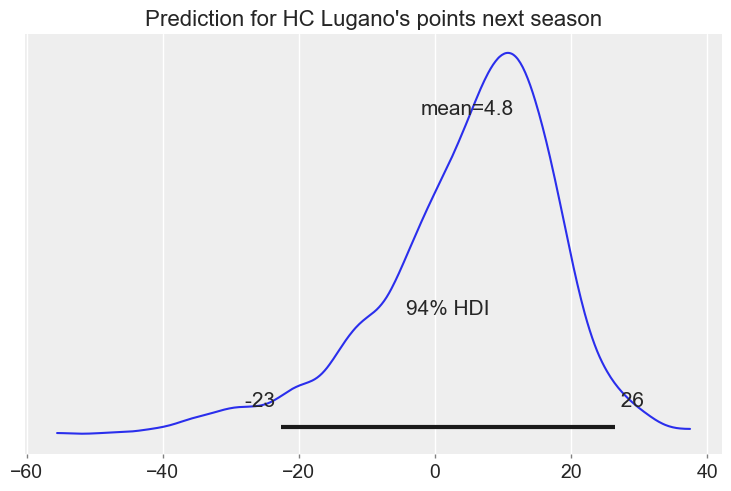

In [14]:
az.plot_posterior(np.array(predictive_distribution))
plt.title("Prediction for HC Lugano's points next season")

## Posterior novel prediction

In [15]:
# Save the team for novel predictions
novel_player_features = points_df.tail(1).iloc[:,3:13].values[0]

x_new = novel_player_features

In [16]:
with pm.Model() as model_pooled_with_prediction:

    alpha = pm.Normal('alpha', mu=mu_y, sigma=s_y)
    beta = pm.Normal('beta', mu=0, sigma=s_x, shape=10)
    sigma = pm.HalfNormal('sigma', sigma=s_y)

    # likelihood:
    mu = alpha + pm.math.dot(x, beta)

    # observed data:
    y_pred = pm.StudentT ('y_pred', nu=4, mu=mu, sd=sigma, observed= y)

    # Novel player
    x_novel = pm.Data("x_novel", x_new)
    mu_novel = alpha + pm.math.dot(x_novel, beta)
    y_novel = pm.Normal("y_novel", mu=mu_novel, sigma=sigma)

In [17]:
with model_pooled_with_prediction:
    # inference:
    trace_novel = pm.sample(1000, tune=1000, cores=2, chains=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_novel, sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


In [18]:
with model_pooled_with_prediction:
    display(az.summary(trace_novel, var_names=['y_novel']))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y_novel,5.646,3.148,-0.303,11.299,0.081,0.06,1512.0,1553.0,1.0


# Unpooled model

In [19]:
unpooled_models = []
unpooled_traces = []
for i in range(hcl_idx-5, hcl_idx):
    # sampling variables
    mu_y = y[i].mean()
    s_y = y[i].std()
    s_x = np.mean(np.std(x[i]))

    # model
    with pm.Model() as unpooled_model:
        # priors:
        alpha = pm.Normal('alpha', mu=mu_y, sigma=s_y)
        beta = pm.Normal('beta', mu=0, sigma=s_x, shape=10)
        sigma = pm.HalfNormal('sigma', sigma=s_y)

        # likelihood:
        mu = alpha + pm.math.dot(x[i], beta)

        # observed data:
        y_pred = pm.StudentT ('y_pred', nu=4, mu=mu, sd=sigma, 
                              observed= y[i])
        trace = pm.sample(1000, tune=1000, chains=2, return_inferencedata=True)

    unpooled_models.append(unpooled_model)
    unpooled_traces.append(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


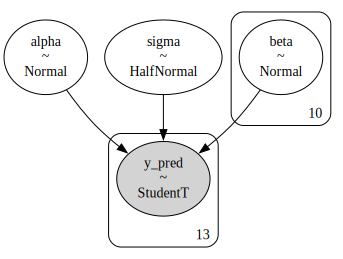

In [20]:
pm.model_to_graphviz(unpooled_models[-1])

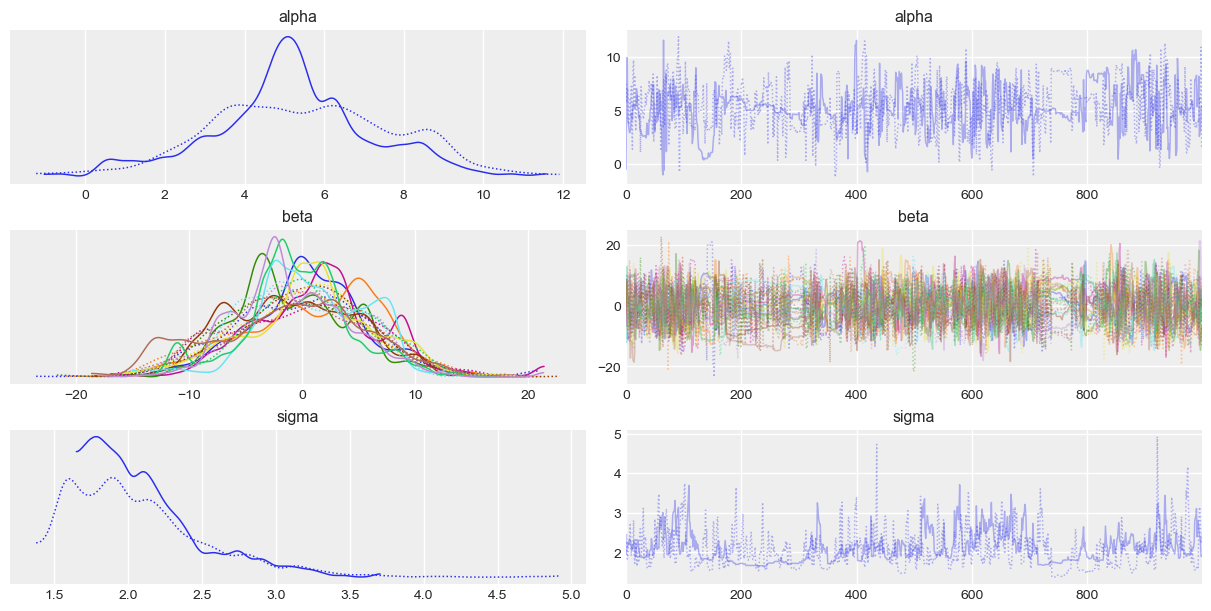

In [21]:
with unpooled_models[-1]:
    az.plot_trace(unpooled_traces[-1])

In [22]:
with unpooled_models[-1]:
    display(az.summary(trace))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,5.323,2.192,1.023,9.294,0.140,0.103,254.0,281.0,1.03
beta[0],0.197,5.679,-10.391,10.632,0.300,0.276,350.0,435.0,1.03
beta[1],0.417,6.252,-11.899,11.216,0.476,0.337,172.0,271.0,1.02
beta[2],-0.692,5.557,-9.488,10.579,0.410,0.290,192.0,434.0,1.02
beta[3],0.744,6.186,-10.990,10.942,0.572,0.405,120.0,411.0,1.03
beta[4],-0.201,5.683,-9.985,10.329,0.444,0.315,178.0,268.0,1.01
beta[5],0.212,5.173,-8.471,9.495,0.732,0.520,46.0,196.0,1.06
beta[6],0.244,5.824,-10.750,11.332,0.359,0.270,268.0,433.0,1.01
beta[7],0.336,5.264,-9.659,11.240,0.398,0.282,162.0,180.0,1.03
beta[8],-0.303,5.395,-10.784,9.541,0.367,0.260,212.0,328.0,1.01


## Posterior prediction of mean for HC Lugano

In [23]:
trace_hcl = unpooled_traces[-1]
model_hcl = unpooled_models[-1]

In [24]:
post_up = az.extract_dataset(trace_hcl.posterior)

alpha_samples = post_up.alpha.values.reshape(2000)
beta_samples = post_up.beta.values.reshape(2000, 10)
mu_team = alpha_samples + np.dot(x_hcl, beta_samples.T)

/var/folders/n3/51xp5_rs54v10cnshxhwyt480000gn/T/ipykernel_13289/1403213277.py:1: FutureWarning: extract_dataset has been deprecated, please use extract
  post_up = az.extract_dataset(trace_hcl.posterior)


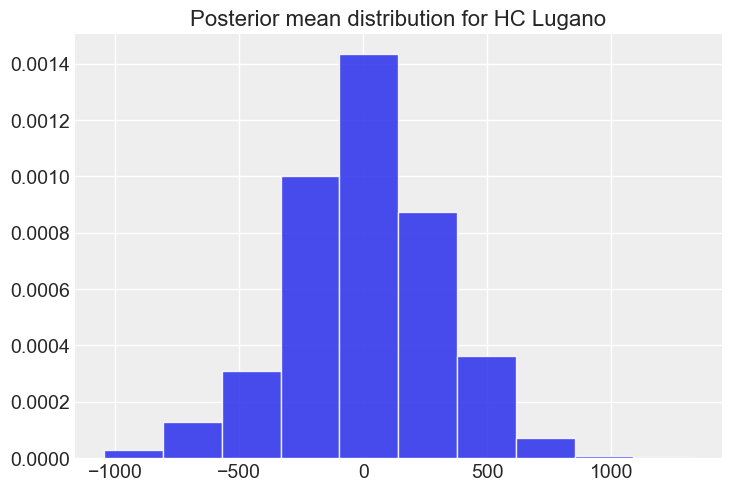

HC Lugano predicted mean: 5.408
HC Lugano predicted mean standard deviation: 296.091


In [25]:
# plot the posterior mean distribution
plt.hist(mu_team, bins=10, density=True, alpha=0.85)
plt.title('Posterior mean distribution for HC Lugano')
plt.show()

# print the mean and standard deviation of the posterior predictive distribution
print(f'HC Lugano predicted mean: {mu_team.mean():.3f}')
print(f'HC Lugano predicted mean standard deviation: {mu_team.std():.3f}')

## Posterior prediction

In [26]:
post_up = az.convert_to_dataset(trace_hcl)
mu_hcl_up = post_up.alpha[-1]
sigma_up = post_up.sigma.values[-1]

y_hcl_unpooled = np.zeros(len(mu_hcl_up))

for i, current_mu in enumerate(mu_hcl_up):
    y_hcl_unpooled[i] = np.random.normal(loc = mu_hcl_up[i], scale = sigma_up[i])

df = pd.DataFrame(y_hcl_unpooled)
df.describe(percentiles=[0.025, 0.975])

,0
count,1000.000000
mean,5.608890
std,3.068504
min,-5.699764
2.5%,-0.635197
50%,5.611178
97.5%,11.500472
max,14.903604


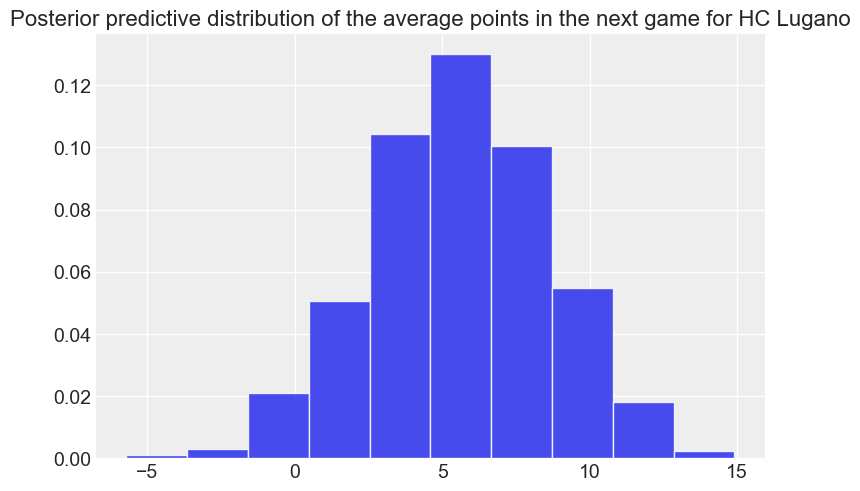

HC Lugano predicted points: 5.609
HC Lugano predicted points standard deviation: 3.067


In [27]:
# plot the posterior predictive distribution
plt.hist(y_hcl_unpooled, bins=10, density=True, alpha=0.85)
plt.title('Posterior predictive distribution of the average points in the next game for HC Lugano')
plt.show()

# print the mean and standard deviation of the posterior predictive distribution
print(f'HC Lugano predicted points: {y_hcl_unpooled.mean():.3f}')
print(f'HC Lugano predicted points standard deviation: {y_hcl_unpooled.std():.3f}')

# Hierarchical model

For this model we assume that all the teams have the same distribution for their coefficients, but also have some variation.

We define the model:
$y_{i,j}$: the team j's observed score for game i.

$\alpha_j$ : the intercept for team j.

$x_i$: the standardized points scored for game i.

$\beta_j$ : the regression coefficients for the j-th feature of the model for team j.

$\epsilon_i$ random variation of the measures.

In this model, we sample $\alpha_j$ and $\beta_j$ values for each team j from a common distribution, with hyper-priors:

$\mu_{\alpha} \sim Normal(\mu_{y}, \sigma_{y})$

$\sigma_{\alpha} \sim HalfNormal(6.8)$

$\mu_{\beta} \sim Normal(0,10)$

$\sigma_{\beta} \sim HalfNormal(10)$

$\sigma \sim HalfNormal(\sigma_{y})$

using 5 different teams.

In [28]:
hier_models = []
hier_traces = []
for i in range(hcl_idx-5, hcl_idx):

    # sampling variables
    mu_y = y[i].mean()
    s_y = y[i].std()
    s_x = np.mean(np.std(x[i]))

    with pm.Model() as hier_model:
        # hyper-priors
        mu_alpha = pm.Normal('mu_alpha', mu=mu_y, sigma=s_y)
        sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=10)
        mu_beta = pm.Normal('mu_beta', mu=0, sigma=10, shape=10)
        sigma_beta = pm.HalfNormal('sigma_beta', sigma=10)
        sigma = pm.HalfNormal('sigma', sigma=s_y)

        # priors
        alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_alpha)
        beta = pm.Normal('beta', mu=mu_beta, sigma=sigma_beta, shape=10)

        # likelihood
        mu = alpha + pm.math.dot(x[i], beta)
        y_pred = pm.StudentT('y_pred', nu=4, mu=mu, sd=sigma, observed=y[i])

        trace = pm.sample(1000, tune=1000, cores=2, chains=2, return_inferencedata=True)
        hier_models.append(hier_model)
        hier_traces.append(trace)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 56 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 62 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 43 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 60 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


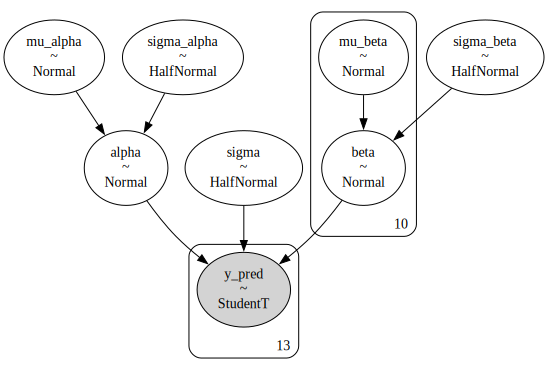

In [29]:
pm.model_to_graphviz(hier_models[-1])

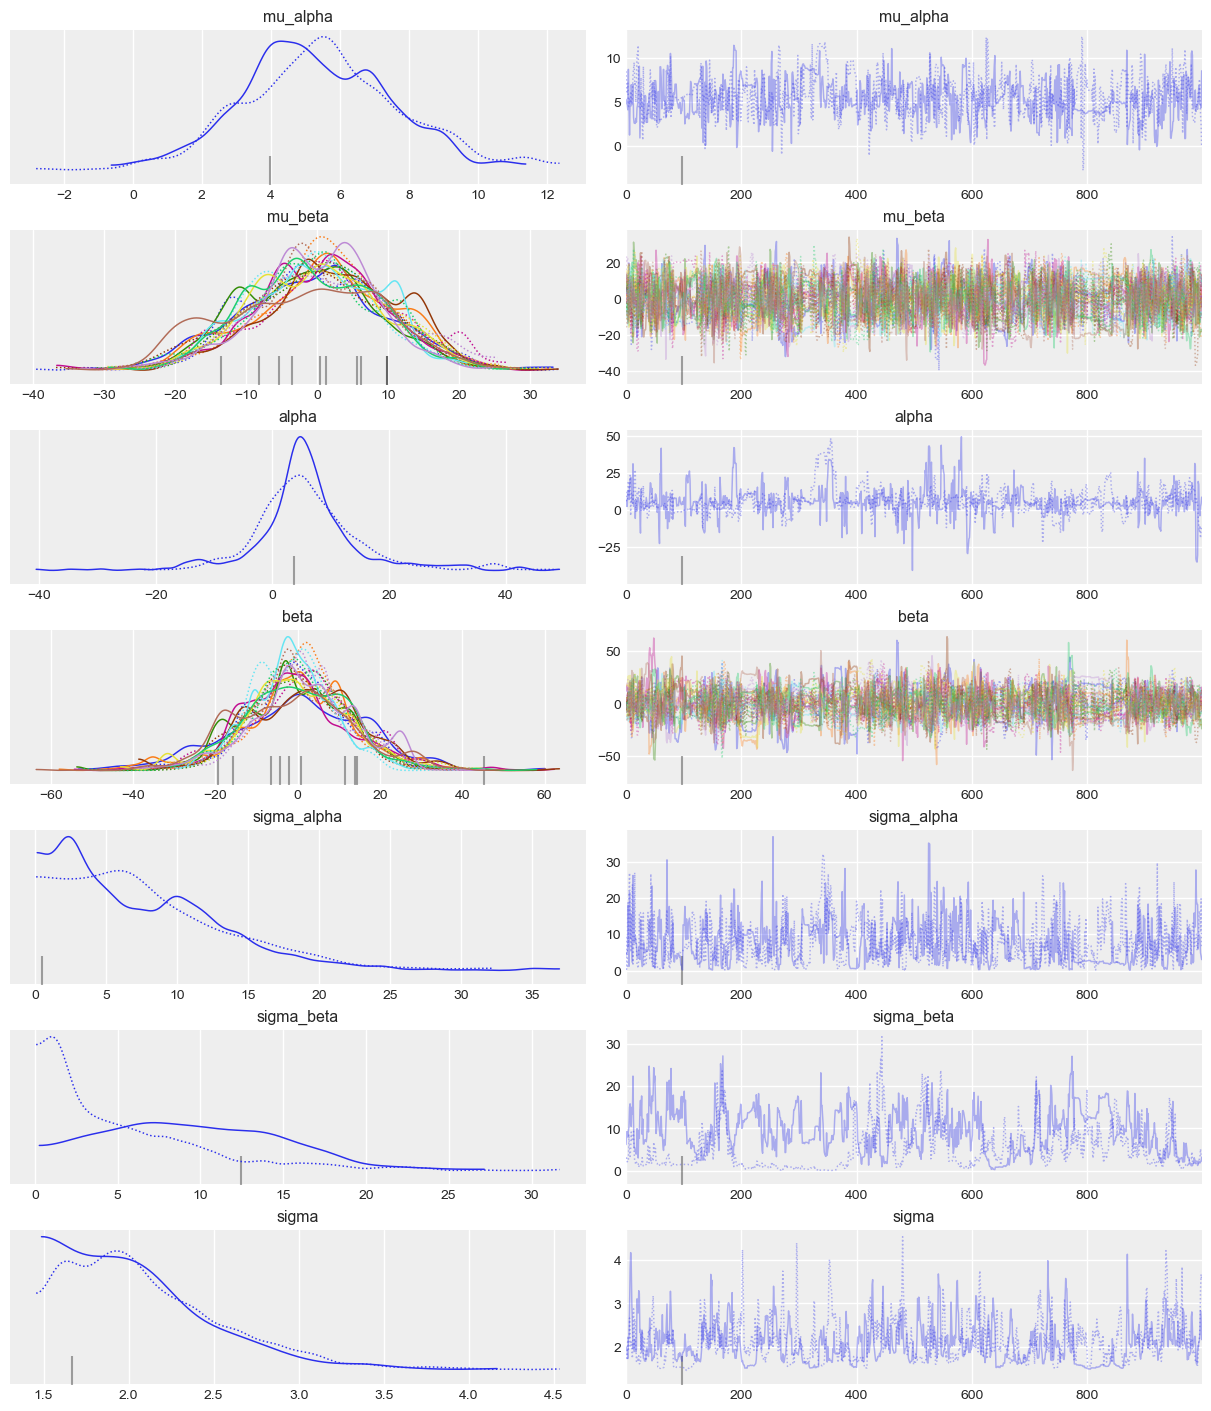

In [30]:
az.plot_trace(hier_traces[-1]);

In [31]:
with unpooled_models[-1]:
    display(az.summary(hier_traces[-1]))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_alpha,5.424,2.254,1.332,9.635,0.125,0.097,328.0,348.0,1.01
mu_beta[0],-0.573,10.222,-19.985,17.755,0.624,0.442,265.0,190.0,1.00
mu_beta[1],0.688,9.513,-18.204,17.151,0.718,0.508,172.0,337.0,1.02
mu_beta[2],-0.300,9.500,-17.109,17.372,0.745,0.527,167.0,327.0,1.01
mu_beta[3],0.878,10.193,-16.888,20.759,0.659,0.500,238.0,143.0,1.01
mu_beta[4],0.479,10.117,-19.855,16.762,0.688,0.487,214.0,334.0,1.03
mu_beta[5],-0.620,8.716,-16.425,15.060,0.662,0.469,176.0,261.0,1.02
mu_beta[6],0.416,9.706,-16.191,18.836,0.617,0.437,255.0,448.0,1.00
mu_beta[7],-0.531,9.271,-18.509,15.664,0.772,0.616,146.0,175.0,1.02
mu_beta[8],0.518,9.230,-15.836,19.133,0.921,0.653,103.0,86.0,1.03


## Posterior mean

In [32]:
trace_hcl_hier = hier_traces[-1]
model_hcl_hier = hier_models[-1]

In [33]:
alpha_samples = trace_hcl_hier.posterior.alpha.values.reshape(2000)
beta_samples = trace_hcl_hier.posterior.beta.values.reshape(2000, 10)
mu_team_hier = alpha_samples + np.dot(x_hcl, beta_samples.T)

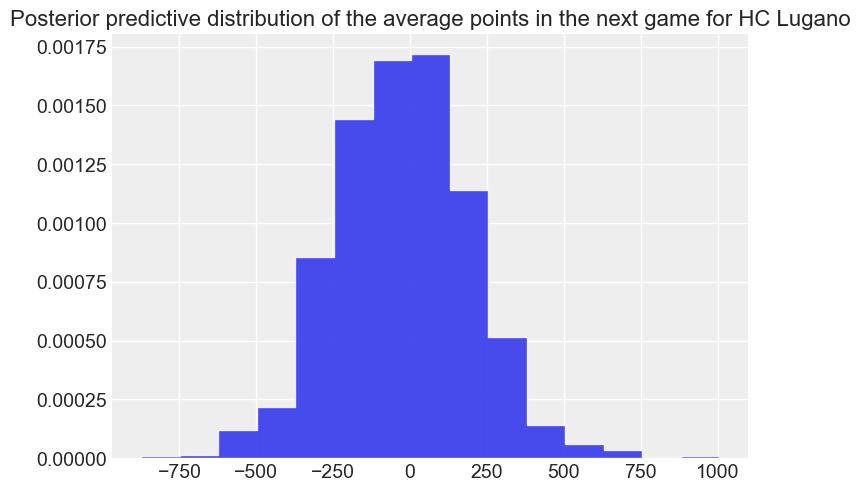

HC Lugano predicted mean: -19.881
HC Lugano predicted mean standard deviation: 219.446


In [34]:
# plot the posterior mean distribution
plt.hist(mu_team_hier, bins=15, density=True,histtype='stepfilled',  alpha=0.85)
plt.title('Posterior predictive distribution of the average points in the next game for HC Lugano')
plt.show()

# print the mean and standard deviation of the posterior predictive distribution
print(f'HC Lugano predicted mean: {mu_team_hier.mean():.3f}')
print(f'HC Lugano predicted mean standard deviation: {mu_team_hier.std():.3f}')

## Posterior prediction

In [35]:
post_hier = az.convert_to_dataset(trace_hcl_hier)
mu_hcl_hier = post_hier.alpha[-1]
sigma_hier = post_hier.sigma.values[-1]

y_hcl_hier = np.zeros(len(mu_hcl_hier))

for i, current_mu in enumerate(mu_hcl_hier):
    y_hcl_hier[i] = np.random.normal(loc = mu_hcl_hier[i], scale = sigma_hier[i])

#the predictions of the hierarchical model are slightly lower and pulled towards the mean of the pooled model.
#yet the difference is small since there are many songs from Beyonce. 
df = pd.DataFrame(y_hcl_hier)
df.describe(percentiles=[0.025, 0.975])

,0
count,1000.000000
mean,6.108520
std,9.378432
min,-24.273322
2.5%,-9.459411
50%,4.992285
97.5%,31.048685
max,49.679353


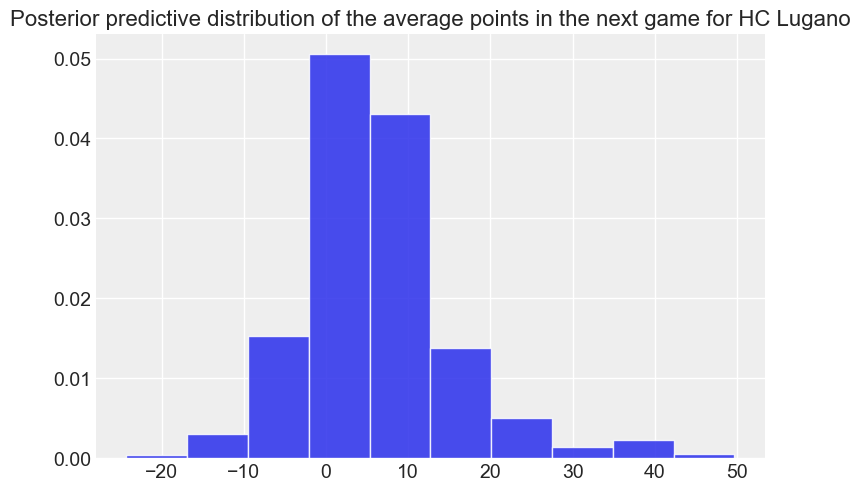

HC Lugano predicted points: 6.109
HC Lugano predicted points standard deviation: 9.374


In [36]:
# plot the posterior predictive distribution
plt.hist(y_hcl_hier, bins=10, density=True, alpha=0.85)
plt.title('Posterior predictive distribution of the average points in the next game for HC Lugano')
plt.show()

# print the mean and standard deviation of the posterior predictive distribution
print(f'HC Lugano predicted points: {y_hcl_hier.mean():.3f}')
print(f'HC Lugano predicted points standard deviation: {y_hcl_hier.std():.3f}')

## Novel prediction

In [37]:
x_new = novel_player_features
x_new = np.array(x_new, dtype=float)

In [38]:
novel_player_features

array([ 1.,  7.,  6.,  0.,  4., 13.,  8.,  6.,  7.,  7.])

In [39]:
with pm.Model() as hier_n_pred:
    # hyper-priors

    mu_alpha = pm.Normal('mu_alpha', mu=3.6, sigma=1.8)
    sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=10)
    mu_beta = pm.Normal('mu_beta', mu=0, sigma=10, shape=10)
    sigma_beta = pm.HalfNormal('sigma_beta', sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=3)

    # priors
    alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_alpha)
    beta = pm.Normal('beta', mu=mu_beta, sigma=sigma_beta, shape=10)

    # likelihood
    mu = alpha + pm.math.dot(x, beta)
    y_pred = pm.StudentT('y_pred', nu=4, mu=mu, sd=sigma, observed=y)

    # Novel player
    x_novel = pm.Data("x_novel", x_new)
    mu_novel = alpha + pm.math.dot(x_novel, beta)
    y_novel = pm.Normal("y_novel", mu=mu_novel, sigma=sigma)

    trace_h_novel = pm.sample(1000, tune=1000, cores=2, chains=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_novel, beta, alpha, sigma, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
There were 187 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5508002659278416, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [40]:
with hier_n_pred:
    display(az.summary(trace_h_novel, var_names=['y_novel']))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y_novel,5.904,2.888,0.481,11.362,0.289,0.205,912.0,1287.0,1.03


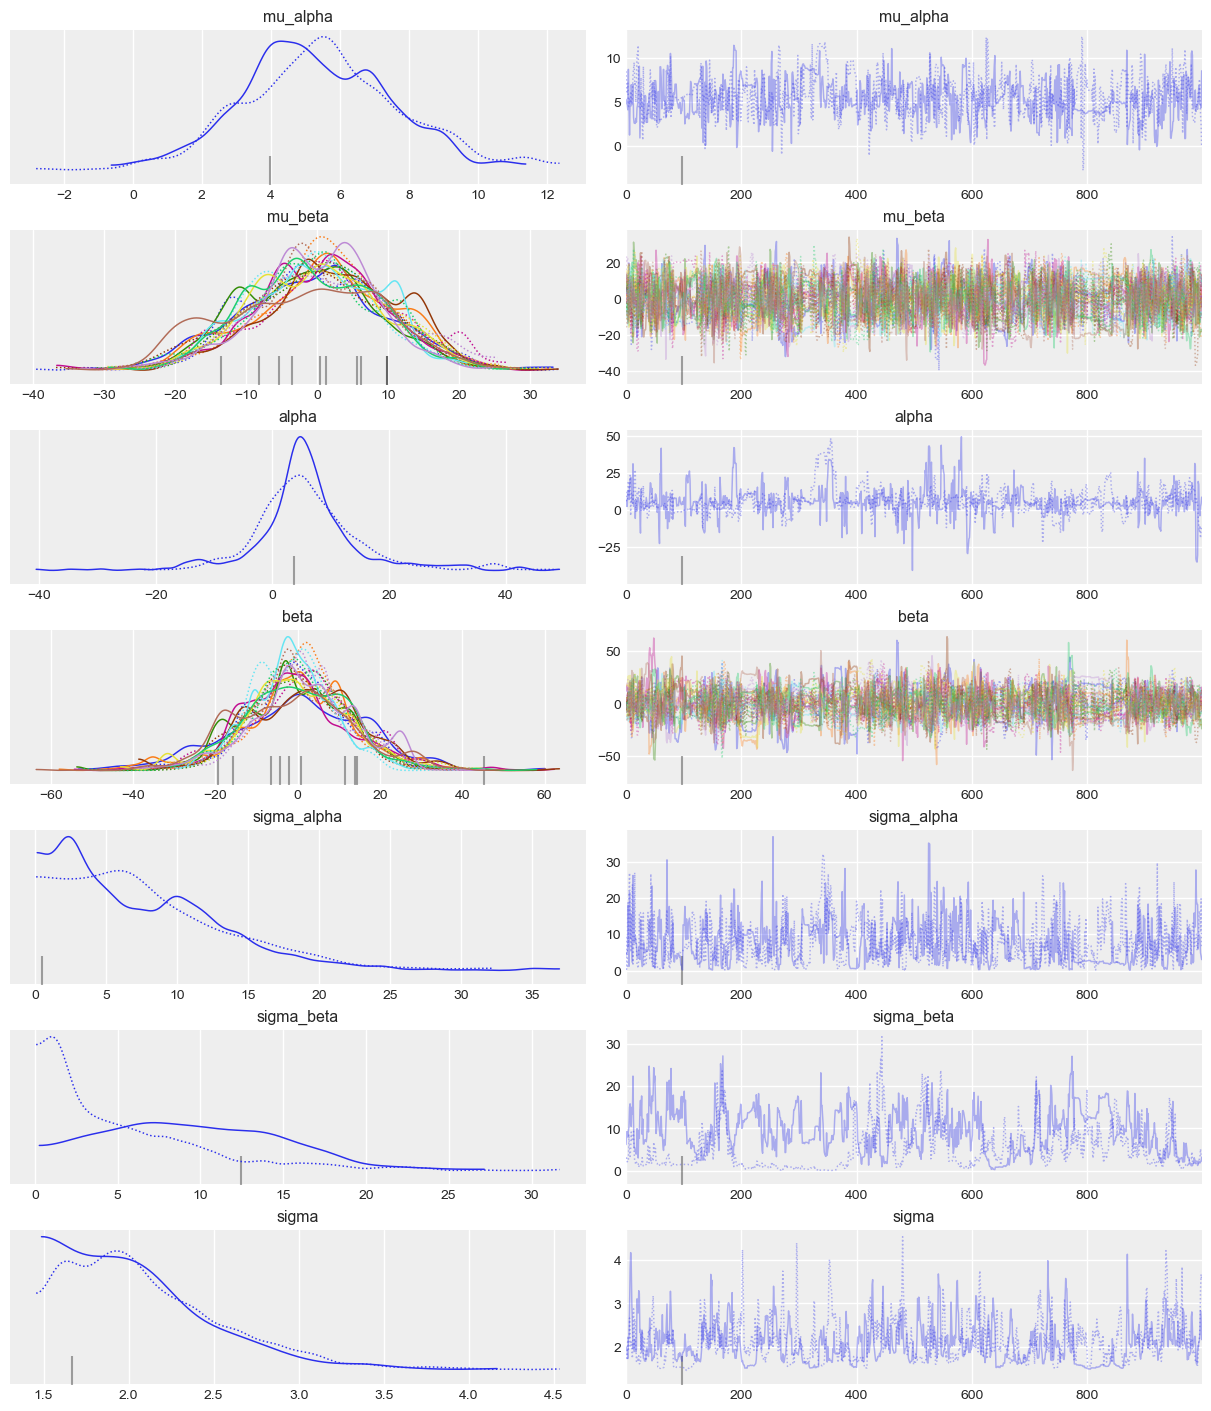

In [41]:
az.plot_trace(hier_traces[-1]);

## Prior sensitivity

In [42]:
hier_models_sens = []
hier_traces_sens = []
for i in range(hcl_idx-5, hcl_idx):
    with pm.Model() as hierarchical_model:
        # hyper-priors
        mu_alpha = pm.Uniform('mu_alpha', 0, 10)
        sigma_alpha = pm.HalfCauchy('sigma_alpha', beta=10)
        mu_beta = pm.Uniform('mu_beta', 0, 10, shape=10)
        sigma_beta = pm.HalfCauchy('sigma_beta', beta=10, shape=10)
        sigma = pm.HalfCauchy('sigma', beta=10)

        # priors
        alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_alpha)
        beta = pm.Normal('beta', mu=mu_beta, sigma=sigma_beta, shape=10)

        # likelihood
        mu = alpha + pm.math.dot(x[i], beta)
        y_pred = pm.StudentT('y_pred', nu=4, mu=mu, sd=sigma, observed=y[i])

        trace = pm.sample(1000, tune=1000, cores=2, chains=2, return_inferencedata=True)
        hier_models_sens.append(hier_model)
        hier_traces_sens.append(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 59 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 68 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 73 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7078950782374245, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 64 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.6675179621918731, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [43]:
trace_hcl_hier = hier_traces_sens[-1]
post_hier = az.convert_to_dataset(trace_hcl_hier)
mu_hcl_hier = post_hier.alpha[-1]
sigma_hier = post_hier.sigma.values[-1]

y_hcl_hier = np.zeros(len(mu_hcl_hier))

for i, current_mu in enumerate(mu_hcl_hier):
    y_hcl_hier[i] = np.random.normal(loc = mu_hcl_hier[i], scale = sigma_hier[i])

#the predictions of the hierarchical model are slightly lower and pulled towards the mean of the pooled model.
#yet the difference is small since there are many songs from Beyonce. 
df = pd.DataFrame(y_hcl_hier)
df.describe(percentiles=[0.025, 0.975])

,0
count,1000.000000
mean,4.598420
std,12.779133
min,-92.328792
2.5%,-16.203836
50%,5.684191
97.5%,23.204228
max,56.210674


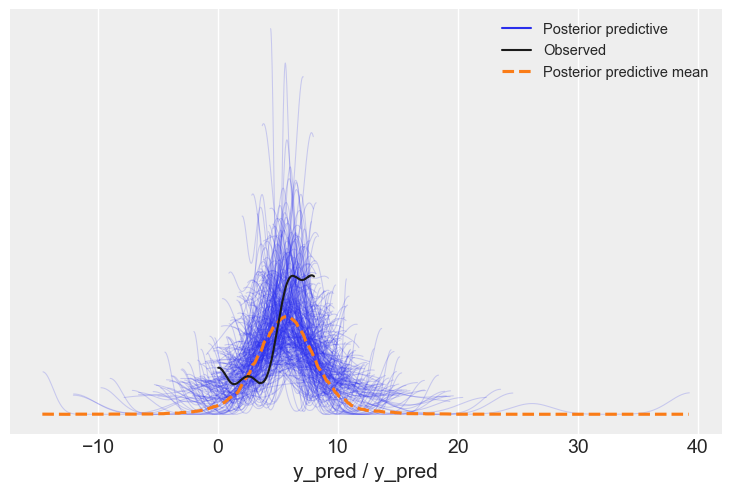

In [44]:
ppc = pm.sample_posterior_predictive(hier_traces[-1], samples=300, model=hier_models[-1])
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=hier_models[-1]));

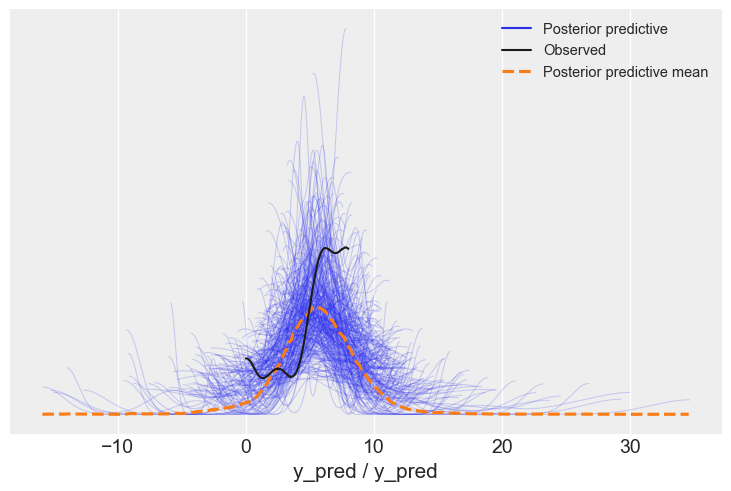

In [45]:
ppc = pm.sample_posterior_predictive(hier_traces_sens[-1], samples=300, model=hier_models_sens[-1])
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=hier_models_sens[-1]));

## WAIC comparison

In [46]:
for i in range(5):
  print(az.waic(hier_traces[i]))

Computed from 2000 posterior samples and 13 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -37.64     2.22
p_waic        1.45        -
Computed from 2000 posterior samples and 13 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -39.38     2.47
p_waic        1.97        -

There has been a warning during the calculation. Please check the results.
Computed from 2000 posterior samples and 13 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -35.96     3.20
p_waic        2.29        -

There has been a warning during the calculation. Please check the results.
Computed from 2000 posterior samples and 13 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -40.31     2.14
p_waic        1.70        -
Computed from 2000 posterior samples and 13 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -30.69     2.87
p_waic        1.41        -


/Users/christian/miniforge3/envs/bda/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/christian/miniforge3/envs/bda/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [47]:
for i in range(5):
  print(az.waic(unpooled_traces[i]))

Computed from 2000 posterior samples and 13 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -37.73     2.25
p_waic        1.55        -
Computed from 2000 posterior samples and 13 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -39.00     2.40
p_waic        1.62        -
Computed from 2000 posterior samples and 13 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -35.80     3.19
p_waic        2.15        -

There has been a warning during the calculation. Please check the results.
Computed from 2000 posterior samples and 13 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -40.27     2.11
p_waic        1.64        -
Computed from 2000 posterior samples and 13 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -30.62     2.85
p_waic        1.33        -


/Users/christian/miniforge3/envs/bda/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


When looking at the values summed up, we see that the hierarchical models is slightly better, with a score of 8.82 compared to the one of the unpooled model of 8.29.

# Comparing the models (hierarchical and pooled) on novelty prediction

In [48]:
print(az.waic(trace_novel))
print(az.waic(trace_h_novel))

Computed from 2000 posterior samples and 208 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -576.47    12.76
p_waic       11.38        -
Computed from 2000 posterior samples and 208 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -576.39    12.74
p_waic       11.12        -
